# Emotion Detection from Text

Import Needed Packages

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Import the Data

<b>Test</b>

Import data.

In [3]:
df_test = pd.read_csv('test.txt',sep=';',header=None)

Rename headings.

In [4]:
df_test.columns = ['text','emotion']

Look at test data size.

In [5]:
df_test.shape

(2000, 2)

Look at first five entries.

In [6]:
df_test.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


<b>Train</b>

Import data.

In [7]:
df_train = pd.read_csv('train.txt',sep=';',header=None)

Rename headings.

In [8]:
df_train.columns = ['text','emotion']

Look at first five entries.

In [9]:
df_train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


We will look at some randomly sampled text form the training dataset.

In [10]:
df_train['text'].sample(10).values

array(['i look at my life my beautiful family the fact that i feel truly blessed and that all that ive asked from god and the universe all that has happened and beyond how my imagination fathomed it',
       'i feel so blessed that i am able to leave there',
       'i feel that all sports are unprotected from the media and on an equal playing field',
       'i doing something that make you feel bothered',
       'i acknowledge that i am not actually fat by definition but feeling uncomfortable in my skin',
       'i feel for you i feel sorry for those who think autistics have no ability to empathize',
       'i feel like every once in a while i should stop trying to do the smart thing and really go for my dreams',
       'i feel incredibly nervous about it',
       'i feel hopeful like things are going to be great and like things are great',
       'i would feel a violent stab of loneliness'], dtype=object)

We see the text is already preprocessed, however, constraction words have been processed by replacing apostrophes with spaces (e.g. don't -> don t).  We will need to condiser this in preprocessing and removal of stop words.

<b>Validation</b>

Import data.

In [11]:
df_val = pd.read_csv('val.txt',sep=';',header=None)

Rename headings.

In [12]:
df_val.columns = ['text','emotion']

Look val data size.

In [13]:
df_val.shape

(2000, 2)

Look at first five entries.

In [14]:
df_val.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


## Analyse the Data

### Catgory List and Number of Categories

In [15]:
#Get unique entries in the categories column to work out number of categories
category_list = df_train.iloc[:,1].unique()
category_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [16]:
#Number of categories
num_cat = len(category_list)
num_cat

6

### Category Counts

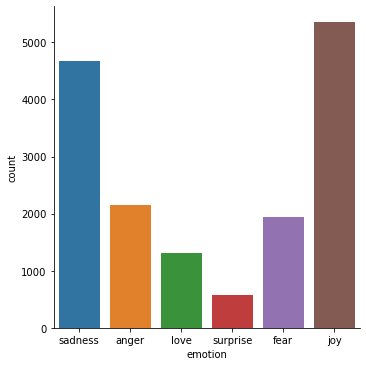

In [17]:
#See frequency of each category in the training data
count_figure = sns.catplot(data=df_train,x='emotion',kind='count')

Training set categories are unbalanced: Finding the ratios w.r.t. the median category.

In [18]:
emotion_counts = df_train.groupby('emotion').count()

In [19]:
emotion_counts

,text
emotion,
anger,2159
fear,1937
joy,5362
love,1304
sadness,4666
surprise,572


In [20]:
emotion_counts.median()

text    2048.0
dtype: float64

Median category is "anger", so we will compare w.r.t. to this category

In [21]:
emotion_counts_norm = emotion_counts['text']/emotion_counts.median().values

In [22]:
emotion_counts_norm

emotion
anger       1.054199
fear        0.945801
joy         2.618164
love        0.636719
sadness     2.278320
surprise    0.279297
Name: text, dtype: float64

We can see there is a max of ~2.6x the median category, a min of ~0.28x the median category.  This is a slight imbalance. 

For slight imbalance, we will start by downsampling the major categories (sadness and joy).  If required we will consider upsampling via smote.

### Under Sampling and Upsampling

In [23]:
#Reduce the higher frequency categories (sadness and joy) to 2000 entries 
df_joy_sample = df_train[df_train['emotion']=='joy'].sample(5362-2000)
df_sad_sample = df_train[df_train['emotion']=='sadness'].sample(4666-2000)

df_train.drop(index=df_joy_sample.index,inplace=True,axis=0)
df_train.drop(index=df_sad_sample.index,inplace=True,axis=0)

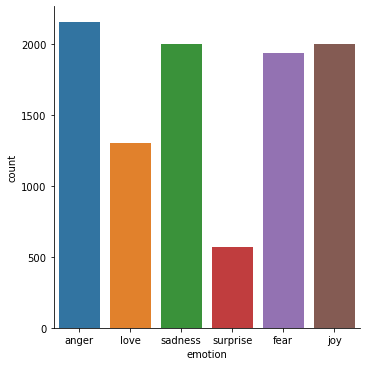

In [24]:
count_figure = sns.catplot(data=df_train,x='emotion',kind='count')

## Analyse the text with WordCloud

In [25]:
from wordcloud import WordCloud, STOPWORDS

Remove punctuation from stop words

In [26]:
STOPWORDS = list(STOPWORDS)
#Removes all punctuation so that stopwords are in same form as preprocessed data for removal
#e.g i'm to im
#Remove anything that is not an alphanumeric character with regex
newSTOPWORDS = [re.sub('[^\w]','',x) for x in STOPWORDS]
stopwords = set(newSTOPWORDS)


In [27]:
#Create one large string of all the entries to analyse with wordcloud
comment_words = ''
for words in df_train['text']:
    comment_words += ' '+ words
       

In [28]:
#initialise wordcloud
wordcloud = WordCloud(width=800,height=800,background_color='white',
                     stopwords=stopwords,min_font_size=10).generate(comment_words) 

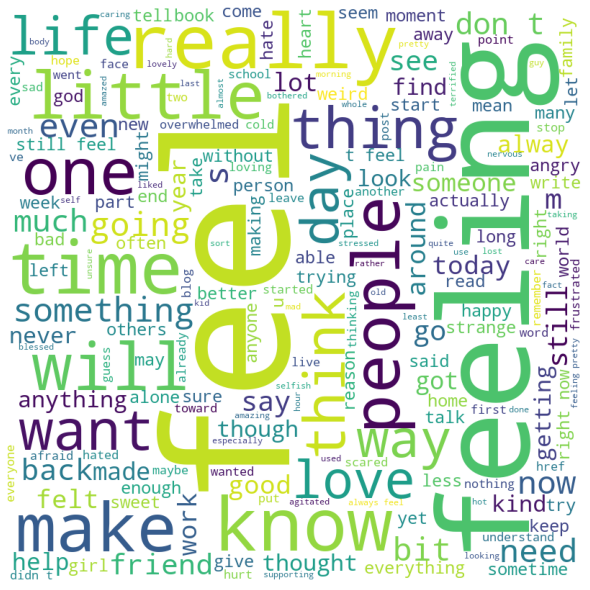

In [29]:
#Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

We see the majority content of the entries in the training data.

## Input-Labels Split

In [30]:
#Make copies of the dataframes to set up as training, validation and testing data
X_train = df_train['text'].copy()
y_train = df_train['emotion'].copy()

X_val = df_val['text'].copy()
y_val = df_val['emotion'].copy()

X_test = df_test['text'].copy()
y_test = df_test['emotion'].copy()

## Text Preprocessing

Text is largely already preprocessed.  Next we will remove the stop words, create a tokenizer and pad the sequences.

Note we need to handle contractions which have been processed into the form (don't -> don t).

In [31]:
def remove_stopwords(df):
    #iterate through all the entries in the dataframe
    for i in range(df.shape[0]):
        #initialise an empty string for processed text
        processed_text = ''
        
        #split the strings based on whitespace
        words = df.iloc[i].split()
        
        #iterate through each word in each data row
        for j in range(len(words)):
            #determine if there is a single letter that may belong to a contraction
            #exclude if the single letter is a, i or u (since these can exist on their own)
            if len(words[j]) == 1 and (words[j] != 'a' and words[j] != 'i' and words[j] != 'u'):
                # merge values to create contractions, remove the single character
                words[j-1]+=words[j]
                words[j] = 'NAN'
        
        #Check if NANs in words
        while 'NAN' in words:
            words.remove('NAN')
        
        for word in words:
            #iterate through each row
            #remove stop words
            if word in stopwords:
                continue
            #append non-stopwords to new string
            processed_text += ' '+word
        #strip any extra spaces
        df.iloc[i] = str.strip(processed_text)


In [32]:
#Process training, validation and testing to remove the stopwords and deal with constractions 
remove_stopwords(X_train)
remove_stopwords(X_val)
remove_stopwords(X_test)

## Create Tokenizer

A Tokenizer will allow us to represent the words in the text as numerical indexes based on frequency of the text in the dataset.

In [33]:
numwords = 1000
tokenizer = Tokenizer(num_words=numwords)
tokenizer.fit_on_texts(X_train)

In [34]:
tokenizer.word_index

{'feel': 1,
 'feeling': 2,
 'really': 3,
 'know': 4,
 'little': 5,
 'time': 6,
 'people': 7,
 'will': 8,
 'want': 9,
 'now': 10,
 'still': 11,
 'one': 12,
 'think': 13,
 'even': 14,
 'bit': 15,
 'life': 16,
 'something': 17,
 'love': 18,
 'things': 19,
 'make': 20,
 'going': 21,
 'way': 22,
 'much': 23,
 'back': 24,
 'need': 25,
 'go': 26,
 'day': 27,
 'feelings': 28,
 'always': 29,
 'see': 30,
 'feels': 31,
 'around': 32,
 'pretty': 33,
 'say': 34,
 'good': 35,
 'right': 36,
 'today': 37,
 'felt': 38,
 'though': 39,
 'work': 40,
 'help': 41,
 'never': 42,
 'made': 43,
 'someone': 44,
 'every': 45,
 'got': 46,
 'quite': 47,
 'lot': 48,
 'less': 49,
 'friends': 50,
 'many': 51,
 'find': 52,
 'away': 53,
 'makes': 54,
 'anything': 55,
 'days': 56,
 'home': 57,
 'getting': 58,
 'without': 59,
 'person': 60,
 'strange': 61,
 'sure': 62,
 'everything': 63,
 'enough': 64,
 'left': 65,
 'remember': 66,
 'world': 67,
 'kind': 68,
 'actually': 69,
 'weird': 70,
 'happy': 71,
 'overwhelmed': 72,

Convert to Sequences

In [35]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [36]:
max_len = max([len(i) for i in train_sequences])
#Check max length of sequences that appear 
#Define max_len to be around this value
print(max_len)
#Define max length of padding
max_len = 30

25


In [37]:
#Pad the sequences, with post padding to allow fixed length for feeding into the Neural Net
padded_train = pad_sequences(train_sequences,maxlen=max_len,padding='post')
padded_val = pad_sequences(val_sequences,maxlen=max_len,padding='post')
padded_test = pad_sequences(test_sequences,maxlen=max_len,padding='post')

## Encode the Categories

In [38]:
#Use a label Binarizer to one-hot encode the potential classification categories
LB_encoder = LabelBinarizer()
LB_encoder.fit(df_train['emotion'])

LabelBinarizer()

In [39]:
#Encode the train, val and test data,
#Reshape into column vectors.

y_enc_train = LB_encoder.transform(np.asarray(df_train['emotion']).reshape(-1,1))
y_enc_val = LB_encoder.transform(np.asarray(df_val['emotion']).reshape(-1,1))
y_enc_test = LB_encoder.transform(np.asarray(df_test['emotion']).reshape(-1,1))

In [40]:
y_enc_train

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

## Resample using SMOTE

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
padded_train,y_enc_train = sm.fit_resample(padded_train,y_enc_train)

## Deep Learning (LSTM)

### Metrics

Our objective is to correctly identify the sentiment of each text entry.  As such, the best metric if F1 score, balancing precision and recall.

In [42]:
import tensorflow_addons as tfa

In [43]:
from keras.callbacks import EarlyStopping
#Early Stop Function, stops training when validation F1 score is maximised
#patience of 2 epochs to prevent stopping too early
es = EarlyStopping(monitor='val_F1', mode='max', verbose=1,patience=2)

### Build the Model

In [44]:
def getmodel(init_lr,num_epochs):
    model = tf.keras.Sequential()
    #Firstly, add an embedding layer to imrpove performance
    #Represents words in a vector space
    model.add(layers.Embedding(numwords,80,input_length=max_len))
    
    #Next add a bidirectional LSTM layer, with bidirectional allowing,
    #Reading of text from right to left and left to right.
    model.add(layers.Bidirectional(layers.LSTM(80)))
    
    #Add a hidden dense layer
    model.add(layers.Dense(25,activation='relu'))
    #Use 50% dropout to assist with model robustness and prevent overfitting
    model.add(layers.Dropout(0.5))
    
    #Output layer representing the probability that the text belongs to one of the 6 categories
    model.add(layers.Dense(6,activation='sigmoid'))
    
    #Compile the model using categorical cross entropy,
    #Optimiser is 'Adam' with a learning rate that decreases with each epoch to reduce step size as training continues
    #Metric chosen as the weighted F1 score
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr,decay=init_lr/num_epochs),metrics=[tfa.metrics.F1Score(average='weighted',name='F1',num_classes=6)])
    
    return model




In [45]:
#Set the memory growth of the GPU to True
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [46]:
#Train the model using the GPU,
#Early stopping added as a callback to stop training when F1 score is maximised on the validation data.
num_epochs = 25
batch = 8
init_lr = 1E-2
with tf.device('/GPU:0'):
    gpu_model = getmodel(init_lr,num_epochs)
    history = gpu_model.fit(x=padded_train,y=y_enc_train,epochs=num_epochs,batch_size=batch,shuffle=True,validation_data=(padded_val,y_enc_val),verbose=1,callbacks=[es])

Epoch 1/25
1620/1620 [==============================] - 21s 11ms/step - loss: 1.4287 - F1: 0.4139 - val_loss: 0.7478 - val_F1: 0.8253
Epoch 2/25
1620/1620 [==============================] - 17s 11ms/step - loss: 0.9488 - F1: 0.6949 - val_loss: 0.5595 - val_F1: 0.8603
Epoch 3/25
1620/1620 [==============================] - 17s 11ms/step - loss: 0.7915 - F1: 0.7334 - val_loss: 0.4886 - val_F1: 0.8579
Epoch 4/25
1620/1620 [==============================] - 17s 11ms/step - loss: 0.7205 - F1: 0.7547 - val_loss: 0.4853 - val_F1: 0.8591
Epoch 4: early stopping


Text(0, 0.5, 'F1Score')

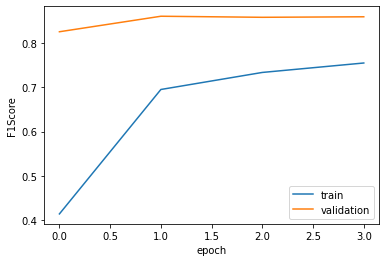

In [47]:
#Plot the evolution of the F1_score with epochs
plt.plot(history.history['F1'],label='train')
plt.plot(history.history['val_F1'],label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('F1Score')


Text(0, 0.5, 'Loss')

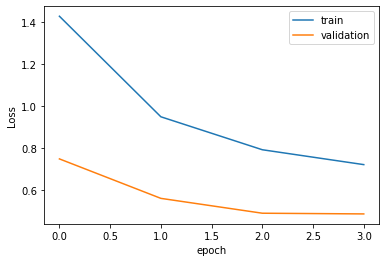

In [48]:
#Plot the evolution of the loss with each epoch
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

In [49]:
#Import confusion matrix for performance evaluation
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score,accuracy_score

In [50]:
#Predict the train, val and test labels
y_test_predict = gpu_model.predict(padded_test)
y_val_predict = gpu_model.predict(padded_val)
y_train_predict = gpu_model.predict(padded_train)

In [51]:
#Convert labels back into text label from One-Hot Encoding
y_test_predict = LB_encoder.inverse_transform(y_test_predict)
y_test_true = LB_encoder.inverse_transform(y_enc_test)

y_val_predict = LB_encoder.inverse_transform(y_val_predict)
y_val_true = LB_encoder.inverse_transform(y_enc_val)

y_train_predict = LB_encoder.inverse_transform(y_train_predict)
y_train_true = LB_encoder.inverse_transform(y_enc_train)

In [52]:
#Import package to normalise the confusion matrices
from sklearn.preprocessing import normalize

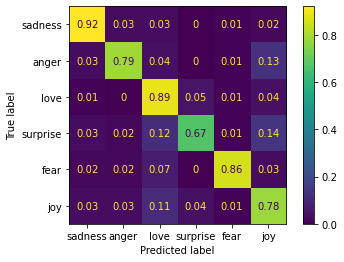

In [53]:
#Train Confusion Matrix
cm = confusion_matrix(y_train_true,y_train_predict)
#normalise the confusion matrix
cm = np.around(normalize(cm,norm='l1'),decimals=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=category_list.tolist())

disp.plot()
plt.show()

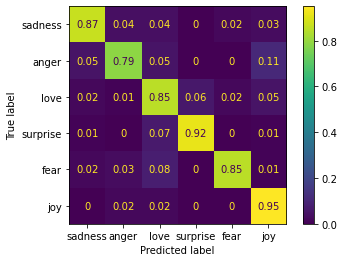

In [54]:
#Val Confusion Matrix
cm = confusion_matrix(y_val_true,y_val_predict)

#normalise the confusion matrix
cm = np.around(normalize(cm,norm='l1'),decimals=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=category_list.tolist())

disp.plot()
plt.show()

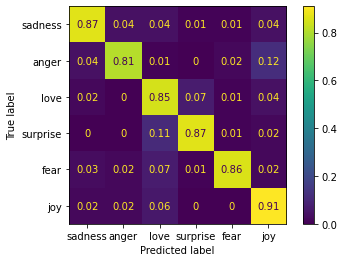

In [55]:
#Test Confusion Matrix
cm = confusion_matrix(y_test_true,y_test_predict)

#normalise the confusion matrix
cm = np.around(normalize(cm,norm='l1'),decimals=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=category_list.tolist())

disp.plot()
plt.show()


### F1 Score for Test Data

In [56]:
f1_test = f1_score(y_test_true,y_test_predict,average=None,labels=category_list.tolist())
print(f1_test)

[0.90892532 0.86642599 0.78186969 0.57692308 0.85176471 0.8722467 ]


### Accuracy Score for Test Data

In [57]:
acc_test = accuracy_score(y_test_true,y_test_predict)
print(acc_test)

0.856


### Save the Model

In [59]:
#gpu_model.save('emotion_detection_LSTM_model.h5')

## Conclusions

Overall, the model performs with an accuracy of approximately 85.6% on the test dataset, and F1 scores ranging from a 58% minimum to a 91% maximum.  The category with the poorest F1 score is 'surprise'.  One potential explanation for the poorer F1 score of could be how the 'surprise' category possessed the smallest categorical frequency in the original training dataset, with SMOTE required to provide balance to the training data which may inject a degree of noise into the training dataset.  Nonetheless, the LSTM model yields good categorisation of sentiment in text for training, validation and the test data. 